# Market Entity Analysis Project
## Using LLMs to Analyze Financial News and Social Media Data

### Project Goals
In this project, you will:
1. Analyze financial news headlines/tweets
2. Extract market entities (companies, stocks, etc.)
3. Analyze sentiment around these entities
4. Create visualizations showing the most discussed entities and their sentiment

### Getting Started with the Data
- Download one of these files from Blackboard:
  - `market_headlines_full.csv`: Complete dataset
  - `market_headlines_1000.csv`: First 1000 rows for testing
- Start with the 1000-row version to test your code
- Switch to the full dataset once your approach works

### Choosing Your LLM
There's a trade-off to consider:
- Larger models (like 70B models:
  - More accurate
  - More expensive
  - Slower
- Smaller models (e.g. 8B models):
  - Faster
  - Cheaper
  - May make more mistakes

Tips:
- Test your approach with smaller models first
- Use the 1000-row dataset for initial testing
- Track costs as you go
- Find the sweet spot between accuracy and cost
- The latest Qwen 7B model or Llama 3.1 8B instruct would be fine for this task

### What You'll Need
- Access to an LLM (Choose one):
  - Google Colab with open-source models
  - Any LLM API of your choice
- Python libraries for data processing and visualization
- Your creativity and analytical thinking!

### Suggested Approach

1. **Entity and Sentiment Extraction**
   - Structure your LLM prompts to return JSON responses
   - Extract multiple entities per headline
   - Include sentiment and analyst information in the JSON
   - Example JSON structure:
     ```json
     {
       "entities": [
         {
           "name": "Microsoft",
           "sentiment": "positive",
           "recommendation": "upgrade"
         },
         // ... more entities
       ]
     }
     ```

2. **Entity Consolidation**
   - Create a system to match different versions of the same entity
     - Company names vs. tickers (Microsoft/MSFT)
     - Common variations (Meta/Facebook)
     - Abbreviations (IBM/International Business Machines)
   - Maintain a mapping of equivalent names

3. **Analysis and Visualization**
   - Aggregate sentiment by entity
   - Track analyst recommendations
   - Create visualizations showing:
     - Most mentioned entities
     - Most positive/negative entities
     - Most controversial entities

### Working Style
- Work alone or in pairs
- Choose your preferred LLM and tools
- Document your strategy clearly

### Notebook Structure
Below this introduction, create your own code and markdown cells for:
1. Loading the CSV data
2. Setting up LLM calls
3. Entity consolidation
4. Analysis and visualization
5. Results and insights

Add comments and markdown explanations as you go!

---
[Start your work below this line]


Sanjana Maila

# Installation and Imports


In [ ]:
%%capture
!pip install openai pandas matplotlib numpy requests

import json
import requests
from typing import List, Dict
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import io
from datetime import datetime



# Defining Core Classes


In [ ]:
class EntityMapper:
    def __init__(self):
        # Dictionary to store company name mappings
        self.mappings = {
            'META': ['Facebook', 'FB'],
            'MSFT': ['Microsoft'],
            'IBM': ['International Business Machines'],
            'GOOGL': ['Google', 'Alphabet'],
            'AMZN': ['Amazon'],
            'AAPL': ['Apple'],
            'NFLX': ['Netflix'],
            'TSLA': ['Tesla']
        }

    def normalize_entity(self, name: str) -> str:
        """Normalize entity names to their canonical form"""
        name = name.upper()
        for canonical, variations in self.mappings.items():
            if name in [v.upper() for v in variations] or name == canonical:
                return canonical
        return name

class CostTracker:
    def __init__(self):
        self.total_tokens = 0
        self.total_cost = 0
        self.calls = 0
        self.cost_per_1k_tokens = 0.0015  # Claude-2 rate, adjust as needed
        self.start_time = datetime.now()

    def update(self, response: Dict):
        """Update costs based on API response"""
        if response and 'usage' in response:
            tokens = response['usage'].get('total_tokens', 0)
            self.total_tokens += tokens
            self.total_cost += (tokens / 1000) * self.cost_per_1k_tokens
            self.calls += 1

    def get_summary(self) -> Dict:
        """Get cost tracking summary"""
        duration = (datetime.now() - self.start_time).total_seconds()
        return {
            'total_tokens': self.total_tokens,
            'total_cost': round(self.total_cost, 4),
            'total_calls': self.calls,
            'average_tokens_per_call': round(self.total_tokens / max(1, self.calls), 2),
            'duration_seconds': round(duration, 2),
            'cost_per_minute': round((self.total_cost / max(1, duration)) * 60, 4)
        }

class NewsAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.entity_mapper = EntityMapper()
        self.cost_tracker = CostTracker()
        self.model = "qwen/qwen-2.5-coder-32b-instruct"

    def make_api_call(self, prompt: str) -> Dict:
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "HTTP-Referer": "https://github.com/openrouter-api",
            "X-Title": "Entity Extractor",
            "Content-Type": "application/json"
        }

        data = {
            "model": self.model,
            "messages": [
                {
                    "role": "system",
                    "content": "You are a financial news analyzer. Extract companies, sentiment, and recommendations from financial news. Always respond in valid JSON format."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            "temperature": 0.1,
            "max_tokens": 1000
        }

        try:
            response = requests.post(
                self.api_url,
                headers=headers,
                json=data,
                timeout=30
            )
            if response.status_code == 200:
                result = response.json()
                self.cost_tracker.update(result)
                return result
            print(f"API Error: Status {response.status_code}")
            print(f"Response: {response.text}")
            return None
        except Exception as e:
            print(f"API call failed: {str(e)}")
            return None

    def extract_entities(self, text: str) -> Dict:
        """Extract entities with Qwen-optimized prompt"""
        prompt = f"""Please analyze this financial news and extract:
1. Company names mentioned
2. Sentiment (must be exactly: positive, negative, or neutral)
3. Analyst recommendations (must be exactly: upgrade, downgrade, hold, or none)

Format the response as JSON like this example:
{{
    "entities": [
        {{
            "name": "APPLE",
            "sentiment": "positive",
            "recommendation": "upgrade"
        }}
    ]
}}

News text: {text}

Remember:
- Only return valid JSON
- Use exact sentiment values: positive, negative, neutral
- Use exact recommendation values: upgrade, downgrade, hold, none
- Include all mentioned companies
"""

        result = self.make_api_call(prompt)

        if result and 'choices' in result:
            try:
                content = result['choices'][0]['message']['content']
                # Find JSON in the response
                json_start = content.find('{')
                json_end = content.rfind('}') + 1

                if json_start >= 0 and json_end > json_start:
                    json_str = content[json_start:json_end]
                    print(f"Extracted JSON: {json_str}")  # Debug output

                    entities = json.loads(json_str)
                    validated_entities = []

                    # Validate and clean each entity
                    for entity in entities.get('entities', []):
                        if self._validate_entity(entity):
                            entity['name'] = self.entity_mapper.normalize_entity(entity['name'])
                            validated_entities.append(entity)
                        else:
                            print(f"Invalid entity format: {entity}")

                    return {"entities": validated_entities}
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {str(e)}")
                print(f"Raw content: {content}")
            except Exception as e:
                print(f"Processing error: {str(e)}")
        return {"entities": []}

    def _validate_entity(self, entity: Dict) -> bool:
        """Validate entity has all required fields with correct values"""
        if not isinstance(entity, dict):
            print(f"Entity is not a dictionary: {entity}")
            return False

        required_fields = {
            'name': str,
            'sentiment': {'positive', 'negative', 'neutral'},
            'recommendation': {'upgrade', 'downgrade', 'hold', 'none'}
        }

        try:
            # Check all fields exist
            if not all(field in entity for field in required_fields):
                missing_fields = [field for field in required_fields if field not in entity]
                print(f"Missing fields: {missing_fields}")
                return False

            # Validate name
            if not isinstance(entity['name'], str) or not entity['name'].strip():
                print(f"Invalid name: {entity['name']}")
                return False

            # Validate sentiment
            if entity['sentiment'] not in required_fields['sentiment']:
                print(f"Invalid sentiment: {entity['sentiment']}")
                return False

            # Validate recommendation
            if entity['recommendation'] not in required_fields['recommendation']:
                print(f"Invalid recommendation: {entity['recommendation']}")
                return False

            return True
        except Exception as e:
            print(f"Validation error: {str(e)}")
            return False

def process_headlines(headlines: List[str], analyzer: NewsAnalyzer, batch_size: int = 50) -> pd.DataFrame:
    """Process headlines with improved error handling"""
    all_entities = []
    total_batches = len(headlines) // batch_size + (1 if len(headlines) % batch_size != 0 else 0)

    print(f"\nProcessing {len(headlines)} headlines in {total_batches} batches")
    print(f"Estimated time: {(len(headlines) * 2) / 60:.1f} minutes (at 2 seconds per headline)")

    try:
        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min(start_idx + batch_size, len(headlines))
            batch = headlines[start_idx:end_idx]

            print(f"\nProcessing batch {batch_num + 1}/{total_batches}")

            batch_entities = []
            for i, headline in enumerate(batch, 1):
                try:
                    print(f"\nProcessing headline {start_idx + i}/{len(headlines)}")
                    print(f"Headline: {headline}")
                    result = analyzer.extract_entities(headline)
                    if result and 'entities' in result:
                        print(f"Entities found: {len(result['entities'])}")
                        batch_entities.extend(result['entities'])
                    sleep(2)  # Rate limiting
                except Exception as e:
                    print(f"Error processing headline {start_idx + i}: {str(e)}")
                    continue

            all_entities.extend(batch_entities)

            # Display batch statistics
            print(f"\nBatch {batch_num + 1} complete:")
            print(f"Entities found in this batch: {len(batch_entities)}")
            print(f"Total entities so far: {len(all_entities)}")

            # Display cost tracking
            cost_summary = analyzer.cost_tracker.get_summary()
            print(f"Current cost: ${cost_summary['total_cost']}")
            print(f"Tokens used: {cost_summary['total_tokens']}")

    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
    except Exception as e:
        print(f"\nUnexpected error: {str(e)}")

    # Create DataFrame with validation
    if all_entities:
        df = pd.DataFrame(all_entities)
        # Ensure required columns exist
        if set(['name', 'sentiment', 'recommendation']).issubset(df.columns):
            df['sentiment_score'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
            df['recommendation_strength'] = df['recommendation'].map({
                'upgrade': 1, 'hold': 0, 'downgrade': -1, 'none': 0
            })
            return df
        else:
            print("Missing required columns in DataFrame")
            print("Available columns:", df.columns)

    # Return empty DataFrame with correct columns if no valid data
    return pd.DataFrame(columns=['name', 'sentiment', 'recommendation',
                               'sentiment_score', 'recommendation_strength'])

    def extract_entities(self, text: str) -> Dict:
        prompt = (
            f"Analyze this financial news and extract companies mentioned, their sentiment, "
            f"and any analyst recommendations. Return only JSON in exactly this format:\n"
            f"{{'entities': ["
            f"  {{'name': 'COMPANY_NAME', "
            f"'sentiment': 'positive/negative/neutral', "
            f"'recommendation': 'upgrade/downgrade/hold/none'}}"
            f"]}}\n\n"
            f"Text: {text}"
        )

        result = self.make_api_call(prompt)

        if result and 'choices' in result:
            try:
                content = result['choices'][0]['message']['content']
                json_start = content.find('{')
                json_end = content.rfind('}') + 1
                if json_start >= 0 and json_end > json_start:
                    entities = json.loads(content[json_start:json_end])
                    # Normalize entity names
                    for entity in entities['entities']:
                        entity['name'] = self.entity_mapper.normalize_entity(entity['name'])
                    return entities
            except:
                pass
        return {"entities": []}



# File Upload and Initial Processing

In [ ]:
def upload_and_process():
    print("Please upload your CSV file with headlines...")
    uploaded = files.upload()

    headlines = []
    total_headlines = 0

    for filename in uploaded.keys():
        content = uploaded[filename].decode('utf-8')
        file_headlines = content.split('\n')
        headlines.extend([h.strip() for h in file_headlines if h.strip()])
        total_headlines = len(headlines)

    print(f"Total headlines loaded: {total_headlines}")

    # Ask user for batch size
    batch_size = input("Enter batch size for processing (recommended: 50-100): ")
    batch_size = int(batch_size) if batch_size.isdigit() else 50

    return headlines, batch_size


# Process Headlines with Batching and Progress Tracking

In [ ]:
def process_headlines_in_batches(headlines, analyzer, batch_size):
    all_entities = []
    total_batches = len(headlines) // batch_size + (1 if len(headlines) % batch_size != 0 else 0)

    print(f"\nProcessing {len(headlines)} headlines in {total_batches} batches")
    print(f"Estimated time: {(len(headlines) * 2) / 60:.1f} minutes (at 2 seconds per headline)")

    try:
        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min(start_idx + batch_size, len(headlines))
            batch = headlines[start_idx:end_idx]

            print(f"\nProcessing batch {batch_num + 1}/{total_batches}")
            print(f"Headlines {start_idx + 1} to {end_idx}")

            batch_entities = []
            for i, headline in enumerate(batch, 1):
                try:
                    print(f"Processing headline {start_idx + i}/{len(headlines)}", end='\r')
                    result = analyzer.extract_entities(headline)
                    if result and 'entities' in result:
                        batch_entities.extend(result['entities'])
                    sleep(2)  # Rate limiting
                except Exception as e:
                    print(f"\nError processing headline {start_idx + i}: {str(e)}")
                    continue

            all_entities.extend(batch_entities)

            # Save intermediate results
            if batch_entities:
                temp_df = pd.DataFrame(all_entities)
                temp_df.to_csv(f'intermediate_results_batch_{batch_num + 1}.csv', index=False)

            # Display intermediate stats
            print(f"\nBatch {batch_num + 1} complete:")
            print(f"Entities found in this batch: {len(batch_entities)}")
            print(f"Total entities so far: {len(all_entities)}")

            # Display cost tracking for this batch
            cost_summary = analyzer.cost_tracker.get_summary()
            print(f"Current cost: ${cost_summary['total_cost']}")
            print(f"Tokens used: {cost_summary['total_tokens']}")

            # Optional batch break
            if batch_num < total_batches - 1:
                user_input = input("\nPress Enter to continue to next batch, or 'q' to quit: ")
                if user_input.lower() == 'q':
                    print("Processing stopped by user")
                    break

    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
    except Exception as e:
        print(f"\nUnexpected error: {str(e)}")
    finally:
        return all_entities

# Main processing code
headlines, batch_size = upload_and_process()

# Initialize analyzer
api_key = "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"  # Replace with your actual API key
analyzer = NewsAnalyzer(api_key)

# Process all headlines
all_entities = process_headlines_in_batches(headlines, analyzer, batch_size)

# Create final DataFrame
df = pd.DataFrame(all_entities)
df['sentiment_score'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df['recommendation_strength'] = df['recommendation'].map({
    'upgrade': 1, 'hold': 0, 'downgrade': -1, 'none': 0
})

# # Save final results
# df.to_csv('final_analysis_results.csv', index=False)
# print("\nFinal results saved to 'final_analysis_results.csv'")

# Display summary
print("\nProcessing Complete!")
print(f"Total headlines processed: {len(headlines)}")
print(f"Total entities extracted: {len(df)}")

Please upload your CSV file with headlines...


Streaming output truncated to the last 5000 lines.
        }
    ]
}
Extracted JSON: {
    "entities": [
        {
            "name": "General Motors",
            "sentiment": "positive",
            "recommendation": "none"
        }
    ]
}
Extracted JSON: {
    "entities": [
        {
            "name": "LumiraDx",
            "sentiment": "neutral",
            "recommendation": "none"
        }
    ]
}
Extracted JSON: {
    "entities": [
        {
            "name": "Honest Company",
            "sentiment": "positive",
            "recommendation": "none"
        },
        {
            "name": "Walmart",
            "sentiment": "neutral",
            "recommendation": "none"
        }
    ]
}
Extracted JSON: {
    "entities": [
        {
            "name": "Blackstone",
            "sentiment": "positive",
            "recommendation": "none"
        },
        {
            "name": "Hudson Pacific Properties",
            "sentiment": "positive",
            "recommendat

In [ ]:
def save_entities_json(entities, filename=None, include_timestamp=True):
    """
    Save extracted entities to a JSON file

    Args:
        entities: List of entities to save
        filename: Optional custom filename (default: None, will use 'extracted_entities')
        include_timestamp: Whether to include timestamp in filename (default: True)
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if filename is None:
        base_filename = "extracted_entities"
    else:
        # Remove .json extension if present
        base_filename = filename.replace('.json', '')

    # Create final filename
    if include_timestamp:
        final_filename = f"{base_filename}_{timestamp}.json"
    else:
        final_filename = f"{base_filename}.json"

    # Format the data
    data_to_save = {
        "extraction_time": datetime.now().isoformat(),
        "total_entities": len(entities),
        "entities": entities
    }

    # Save with pretty printing
    with open(final_filename, 'w', encoding='utf-8') as f:
        json.dump(data_to_save, f, indent=2, ensure_ascii=False)

    print(f"\nSaved {len(entities)} entities to {final_filename}")
    return final_filename

# Usage example:
# Save raw entities
save_entities_json(all_entities)

# Save processed DataFrame records
processed_entities = df.to_dict('records')
save_entities_json(processed_entities, filename="processed_entities")


Saved 1503 entities to extracted_entities_20241118_232252.json

Saved 0 entities to processed_entities_20241118_232252.json


'processed_entities_20241118_232252.json'

# Creating DataFrame and Adding Metrics

In [ ]:
df = pd.DataFrame(all_entities)
df['sentiment_score'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df['recommendation_strength'] = df['recommendation'].map({
    'upgrade': 1, 'hold': 0, 'downgrade': -1, 'none': 0
})

# Display the DataFrame
print("Processed Data:")
display(df)

Processed Data:


,name,sentiment,recommendation,sentiment_score,recommendation_strength
0,AAPL,neutral,none,0,0
1,AAPL,neutral,none,0,0
2,AMZN,neutral,none,0,0
3,TSLA,neutral,none,0,0
4,PALANTIR,neutral,none,0,0
...,...,...,...,...,...
1498,VESTA,neutral,none,0,0
1499,RUN THE JEWELS,neutral,none,0,0
1500,BROOKLYN BREWERY,neutral,none,0,0
1501,GOOGL,positive,none,1,0


# visualization

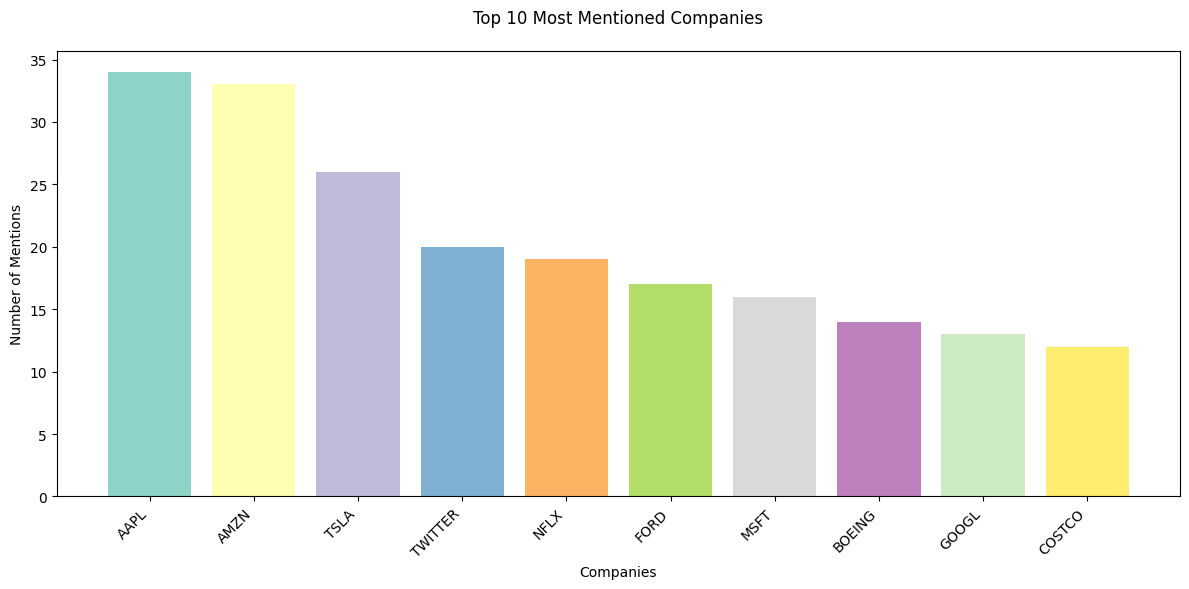

In [ ]:
#Top Companies Bar Chart
plt.figure(figsize=(12, 6))
company_counts = df['name'].value_counts().head(10)
colors = plt.cm.Set3(np.linspace(0, 1, len(company_counts)))

plt.bar(range(len(company_counts)), company_counts.values, color=colors)
plt.title('Top 10 Most Mentioned Companies', pad=20)
plt.xlabel('Companies')
plt.ylabel('Number of Mentions')
plt.xticks(range(len(company_counts)), company_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

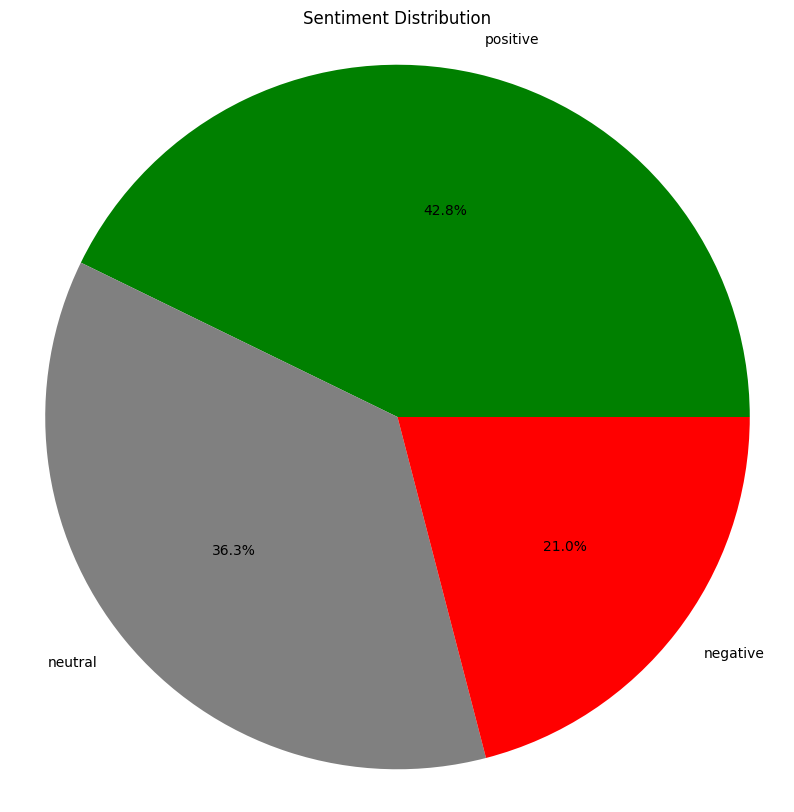


Sentiment Distribution:
positive: 643 (42.8%)
neutral: 545 (36.3%)
negative: 315 (21.0%)


In [ ]:
# Sentiment Distribution Pie Chart
plt.figure(figsize=(10, 10))
sentiment_counts = df['sentiment'].value_counts()
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
plt.pie(sentiment_counts, labels=sentiment_counts.index,
        autopct='%1.1f%%', colors=[colors.get(s, 'blue') for s in sentiment_counts.index])
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

# Print sentiment statistics
print("\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/len(df)*100:.1f}%)")

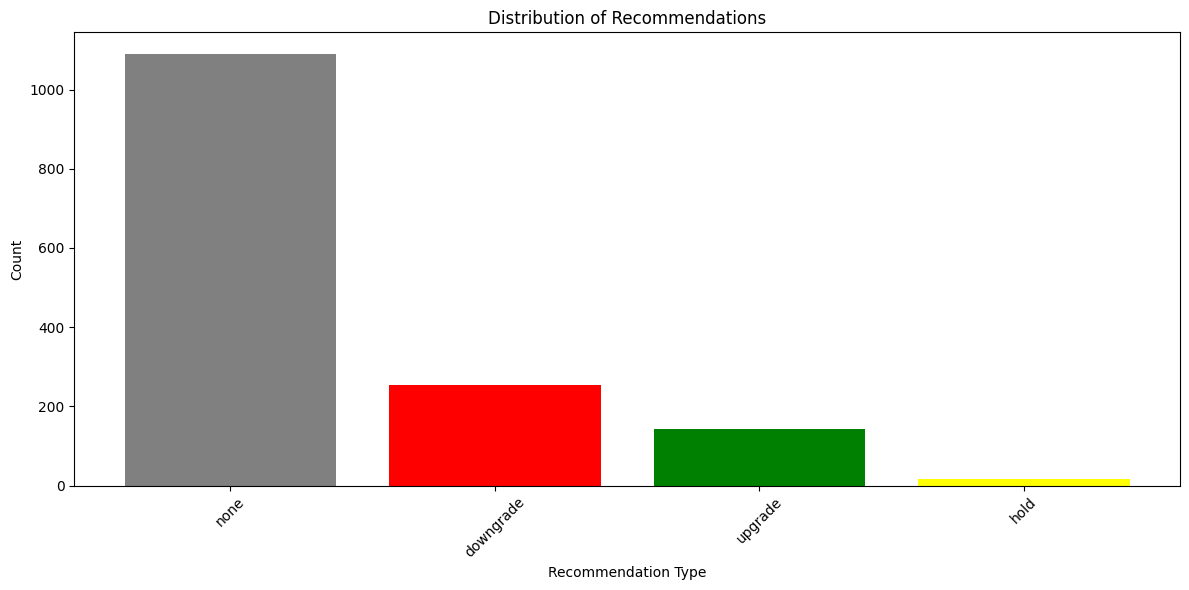


Recommendation Distribution:
none: 1090 (72.5%)
downgrade: 254 (16.9%)
upgrade: 143 (9.5%)
hold: 16 (1.1%)


In [ ]:
# Recommendations Distribution Bar Chart
plt.figure(figsize=(12, 6))
rec_counts = df['recommendation'].value_counts()
rec_colors = {
    'upgrade': 'green',
    'downgrade': 'red',
    'hold': 'yellow',
    'none': 'gray'
}

plt.bar(range(len(rec_counts)), rec_counts.values,
       color=[rec_colors.get(r, 'blue') for r in rec_counts.index])
plt.title('Distribution of Recommendations')
plt.xlabel('Recommendation Type')
plt.ylabel('Count')
plt.xticks(range(len(rec_counts)), rec_counts.index, rotation=45)
plt.tight_layout()
plt.show()

# Print recommendation statistics
print("\nRecommendation Distribution:")
for rec, count in rec_counts.items():
    print(f"{rec}: {count} ({count/len(df)*100:.1f}%)")

# Company Sentiment Analysis with Controversy Score

In [ ]:
def visualize_top_controversy(df: pd.DataFrame, top_n: int = 15):
    """Create visualization for top controversial companies"""
    def calculate_controversy_score(group_df):
        mentions = len(group_df)
        if mentions < 2:
            return 0
        sentiment_std = np.std(group_df['sentiment_score'])
        rec_diversity = len(group_df['recommendation'].unique()) / mentions
        return (sentiment_std + rec_diversity) / 2

    # Calculate controversy scores
    company_scores = df.groupby('name').apply(calculate_controversy_score)
    top_companies = company_scores.sort_values(ascending=False).head(top_n)

    # Create visualization
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_companies)),
                   top_companies.values,
                   height=0.6,
                   color=plt.cm.RdYlBu(np.linspace(0, 1, len(top_companies))))

    # Customize appearance
    plt.title(f'Top {top_n} Most Controversial Companies\nBased on Sentiment Variance and Recommendation Diversity',
             pad=20, fontsize=12, fontweight='bold')
    plt.xlabel('Controversy Score', fontsize=10, labelpad=10)

    # Format y-axis
    plt.yticks(range(len(top_companies)),
              top_companies.index,
              fontsize=10)

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{width:.2f}',
                va='center',
                fontsize=9)

    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [ ]:
# Cell 2: Create Detailed Scores DataFrame
def create_controversy_df(df: pd.DataFrame) -> pd.DataFrame:
    """Create a DataFrame with detailed controversy scores"""

    def calculate_detailed_metrics(group_df):
        mentions = len(group_df)
        company_name = group_df['name'].iloc[0]

        if mentions < 2:
            return pd.Series({
                'Company': company_name,
                'Controversy_Score': 0,
                'Mentions': mentions,
                'Sentiment_Std': 0,
                'Recommendation_Diversity': 0,
                'Positive_Mentions': 0,
                'Negative_Mentions': 0,
                'Neutral_Mentions': 0,
                'Most_Common_Recommendation': 'insufficient data'
            })

        sentiment_std = np.std(group_df['sentiment_score'])
        unique_recs = len(group_df['recommendation'].unique())
        rec_diversity = unique_recs / mentions
        controversy_score = (sentiment_std + rec_diversity) / 2

        sentiment_counts = group_df['sentiment'].value_counts()
        most_common_rec = group_df['recommendation'].mode().iloc[0]

        return pd.Series({
            'Company': company_name,
            'Controversy_Score': round(controversy_score, 3),
            'Mentions': mentions,
            'Sentiment_Std': round(sentiment_std, 3),
            'Recommendation_Diversity': round(rec_diversity, 3),
            'Positive_Mentions': sentiment_counts.get('positive', 0),
            'Negative_Mentions': sentiment_counts.get('negative', 0),
            'Neutral_Mentions': sentiment_counts.get('neutral', 0),
            'Most_Common_Recommendation': most_common_rec
        })

    controversy_df = df.groupby('name').apply(calculate_detailed_metrics).reset_index(drop=True)

    # Add percentage columns
    total_mentions = controversy_df['Mentions']
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        controversy_df[f'{sentiment}_Ratio'] = (
            controversy_df[f'{sentiment}_Mentions'] / total_mentions * 100
        ).round(1)

    # Sort by controversy score
    controversy_df = controversy_df.sort_values('Controversy_Score', ascending=False)

    return controversy_df



<ipython-input-15-d9d13e58e274>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_scores = df.groupby('name').apply(calculate_controversy_score)


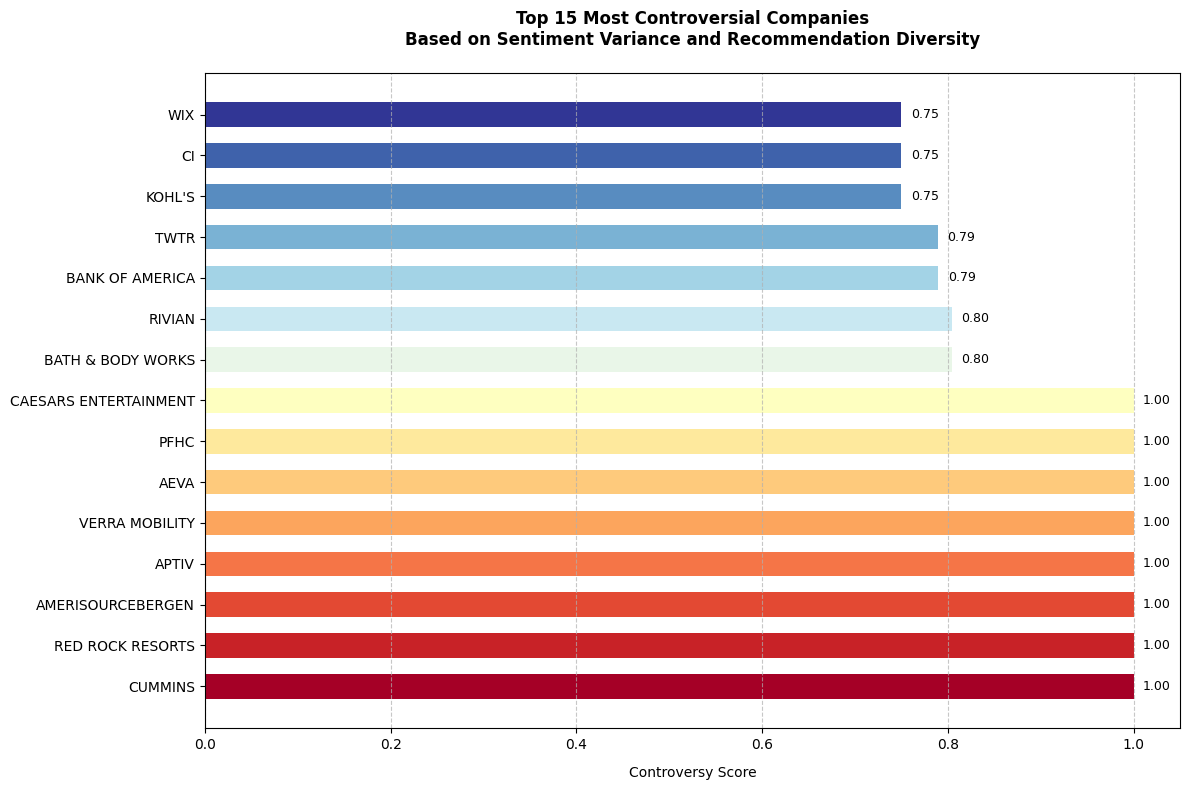

In [ ]:
# First, visualize top 15
visualize_top_controversy(df, top_n=15)



In [ ]:
scores_df = create_controversy_df(df)

# Format DataFrame display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Display scores
print("\nDetailed Controversy Scores:")
print("="*100)
display(scores_df)

# Print summary statistics
print("\nSummary Statistics:")
print("="*100)
print(f"Total Companies Analyzed: {len(scores_df)}")
print(f"Companies with Controversy Score > 0: {len(scores_df[scores_df['Controversy_Score'] > 0])}")
print(f"Average Controversy Score: {scores_df['Controversy_Score'].mean():.3f}")
print(f"Maximum Controversy Score: {scores_df['Controversy_Score'].max():.3f}")
print(f"Most Controversial Company: {scores_df.iloc[0]['Company']}")
print(f"Most Mentioned Company: {scores_df.loc[scores_df['Mentions'].idxmax(), 'Company']}")


Detailed Controversy Scores:


<ipython-input-16-214c2460803b>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  controversy_df = df.groupby('name').apply(calculate_detailed_metrics).reset_index(drop=True)


,Company,Controversy_Score,Mentions,Sentiment_Std,Recommendation_Diversity,Positive_Mentions,Negative_Mentions,Neutral_Mentions,Most_Common_Recommendation,Positive_Ratio,Negative_Ratio,Neutral_Ratio
258,CUMMINS,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
800,RED ROCK RESORTS,1.000,2,1.000,1.000,1,1,0,none,50.000,50.000,0.000
63,AMERISOURCEBERGEN,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
86,APTIV,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
1000,VERRA MOBILITY,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
36,AEVA,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
751,PFHC,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
175,CAESARS ENTERTAINMENT,1.000,2,1.000,1.000,1,1,0,downgrade,50.000,50.000,0.000
131,BATH & BODY WORKS,0.805,3,0.943,0.667,2,1,0,upgrade,66.700,33.300,0.000
814,RIVIAN,0.805,3,0.943,0.667,1,2,0,none,33.300,66.700,0.000



Summary Statistics:
Total Companies Analyzed: 1074
Companies with Controversy Score > 0: 158
Average Controversy Score: 0.067
Maximum Controversy Score: 1.000
Most Controversial Company: CUMMINS
Most Mentioned Company: AAPL


# Saving Results and Displaying Final Summary

In [ ]:
# Display final summary
print("\nFinal Analysis Summary:")
print(f"Total companies analyzed: {len(df['name'].unique())}")
print(f"Total mentions processed: {len(df)}")
print(f"Average sentiment score: {df['sentiment_score'].mean():.2f}")
print(f"Most positive company: {df.groupby('name')['sentiment_score'].mean().idxmax()}")
print(f"Most negative company: {df.groupby('name')['sentiment_score'].mean().idxmin()}")

print(f"\nMost controversial companies (top 3):")
for company, score in company_controversy.head(3).items():
    print(f"- {company}: {score:.3f}")

# Display cost tracking summary
cost_summary = analyzer.cost_tracker.get_summary()
print("\nCost Analysis:")
print(f"Total API calls: {cost_summary['total_calls']}")
print(f"Total tokens used: {cost_summary['total_tokens']}")
print(f"Average tokens per call: {cost_summary['average_tokens_per_call']}")
print(f"Total cost: ${cost_summary['total_cost']}")
print(f"Cost per minute: ${cost_summary['cost_per_minute']}")
print(f"Total processing time: {cost_summary['duration_seconds']} seconds")


Final Analysis Summary:
Total companies analyzed: 1074
Total mentions processed: 1503
Average sentiment score: 0.22
Most positive company: 15FIVE
Most negative company: 1LIFE HEALTHCARE

Most controversial companies (top 3):
- CAESARS ENTERTAINMENT: 1.000
- AMERISOURCEBERGEN: 1.000
- RED ROCK RESORTS: 1.000

Cost Analysis:
Total API calls: 1001
Total tokens used: 270686
Average tokens per call: 270.42
Total cost: $0.406
Cost per minute: $0.0051
Total processing time: 4768.39 seconds
